In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
sns.set(style="darkgrid")

from kats.tsfeatures.tsfeatures import TsFeatures as tsf
from scipy.signal import periodogram,welch

In [2]:
def gen_random_walk(
    num = 1000,
    mean = 0,
    sigma = 0.1,
    min_val = -100,
    max_val = 100
):
    vals = [mean]
    curr = mean
    for i in range(num-1):
        delta = np.random.normal(mean,sigma,1)[0]    
        if (delta>0 and curr+delta>max_val) or (delta<0 and curr+delta<min_val): 
            delta = -delta     
        curr = curr+delta        
        vals.append(curr)
        
    return np.array(vals)

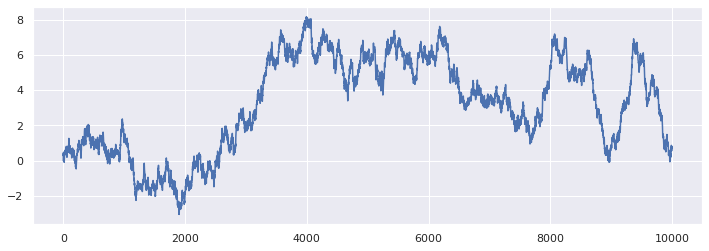

In [3]:
plt.figure(figsize=(12,4))
plt.plot(gen_random_walk(10000))

In [4]:
def gen_sin_wave(
    num_samples = 100,
    sample_freq = 1,
    wave_freq = 5,    
    amplitude = 10,
    noise_sigma = 0.5,    
    mean = 10,
):
    t = num_samples/sample_freq
    x = np.linspace(0,t,num_samples)
    y = amplitude*np.sin(wave_freq*2*np.pi*x)+mean+np.random.normal(0,noise_sigma,len(x)) 
    return y

def gen_anomaly(
    vals, 
    sample_freq,     
    wave_config#(freq, len, amplitude)
):
    sections = []
    for config in wave_config:
        wave_len = config[1]
        start = random.randint(0, len(vals)-wave_len)
        mean = vals[start:start+wave_len].mean()  
        if config[0] == 0:
            wave = [mean]*wave_len
        else:
            wave = gen_sin_wave(
                                num_samples = wave_len,
                                sample_freq = sample_freq,
                                amplitude=config[2],
                                wave_freq=config[0],
                                mean=mean,noise_sigma=0.01)
        vals[start:start+wave_len] = wave
        sections.append((start,start+wave_len))
    return vals, sections   

x = gen_random_walk(10000)

x, sections = gen_anomaly(x,sample_freq=100, wave_config=[(1,400,1),(2,400,0.5),(0.5,600,3),(0,400,0)])

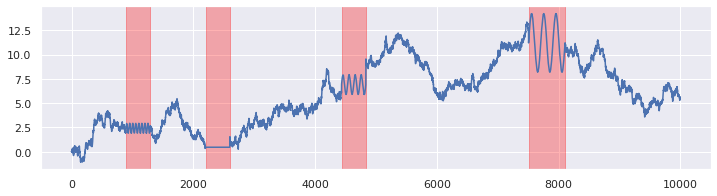

In [5]:
plt.figure(figsize=(12,3))
plt.plot(x)
for section in sections:
    plt.axvspan(section[0],section[1],color='red', alpha=0.3)
plt.show()

In [18]:
def spectral_entropy(x, freq, nfft=None):    
    _, psd = periodogram(x, freq, nfft = nfft)   
    # calculate shannon entropy of normalized psd
    psd_norm = psd / np.sum(psd)
    entropy = np.nansum(psd_norm * np.log2(psd_norm))
    return -(entropy / np.log2(psd_norm.size))

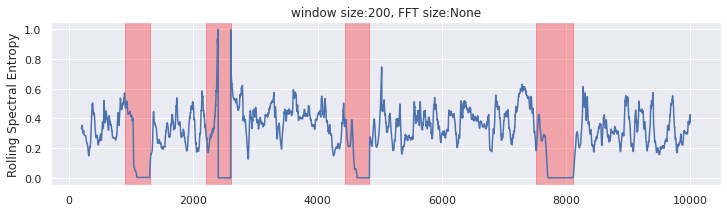

In [33]:
window = 200
nfft = None
df = pd.DataFrame(data=x, columns=['x'])
df['x_roll_se'] = df['x'].rolling(window).apply(lambda x: spectral_entropy(x,freq=100,nfft=nfft))
plt.figure(figsize=(12,3))
plt.plot(df['x_roll_se'])
plt.ylabel('Rolling Spectral Entropy')
for section in sections:
    plt.axvspan(section[0],section[1],color='red', alpha=0.3)
plt.title(f'window size:{window}, FFT size:{nfft}')    
plt.show()

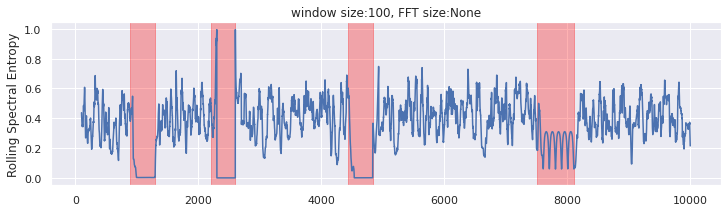

In [35]:
window = 100
nfft = None
df = pd.DataFrame(data=x, columns=['x'])
df['x_roll_se'] = df['x'].rolling(window).apply(lambda x: spectral_entropy(x,freq=100,nfft=nfft))
plt.figure(figsize=(12,3))
plt.plot(df['x_roll_se'])
plt.ylabel('Rolling Spectral Entropy')
for section in sections:
    plt.axvspan(section[0],section[1],color='red', alpha=0.3)
plt.title(f'window size:{window}, FFT size:{nfft}')    
plt.show()

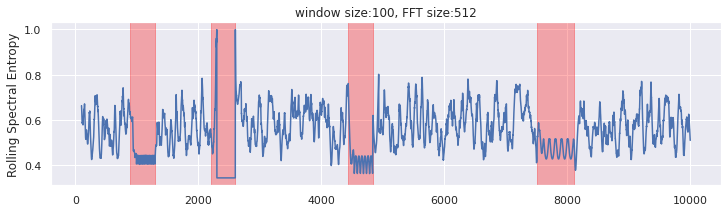

In [32]:
window = 100
nfft = 512
df = pd.DataFrame(data=x, columns=['x'])
df['x_roll_se'] = df['x'].rolling(window).apply(lambda x: spectral_entropy(x,freq=100,nfft=nfft))
plt.figure(figsize=(12,3))
plt.plot(df['x_roll_se'])
plt.ylabel('Rolling Spectral Entropy')
for section in sections:
    plt.axvspan(section[0],section[1],color='red', alpha=0.3)
plt.title(f'window size:{window}, FFT size:{nfft}')    
plt.show()

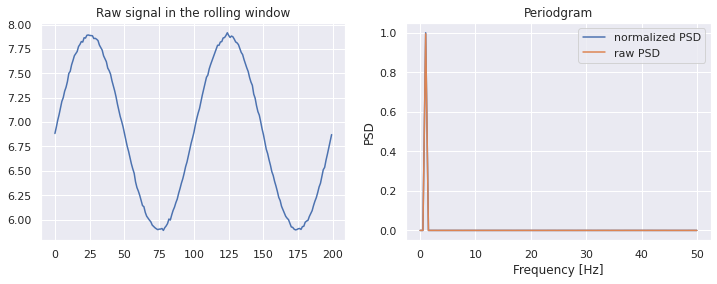

In [42]:
val = x[sections[0][0]:sections[0][0]+200]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Raw signal in the rolling window')
plt.plot(val)
f, psd = periodogram(val, 100, scaling='density')
psd_norm = psd / np.sum(psd)
plt.subplot(1,2,2)
plt.plot(f,psd_norm, label='normalized PSD')
plt.plot(f,psd, label='raw PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Periodgram')
plt.legend()
# plt.xlim(0,10)
plt.show()

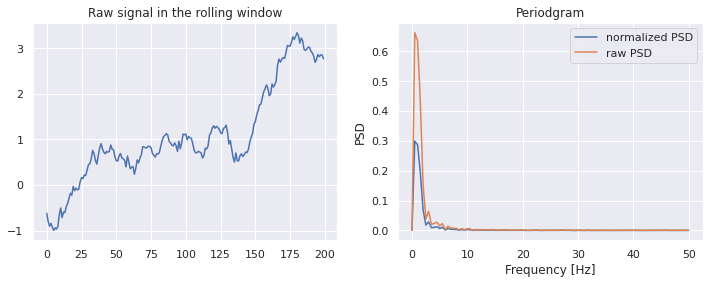

In [44]:
val = x[200:400]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Raw signal in the rolling window')
plt.plot(val)
f, psd = periodogram(val,100, scaling='density')
psd_norm = psd / np.sum(psd)
plt.subplot(1,2,2)
plt.plot(f,psd_norm, label='normalized PSD')
plt.plot(f,psd, label='raw PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Periodgram')
plt.legend()
plt.show()

In [1]:
# a = np.array([0.25,0.25,0.25,0.25])
# -np.nansum(a*np.log2(a))